In [1]:
%matplotlib inline

In [2]:
import roms_tools as rt
from pathlib import Path
import datetime as dt
from dask.diagnostics import ProgressBar
rt.__version__

'2.2.1'

In [3]:
outdir = Path("input_datasets_netcdf")
partdir = Path("input_netcdf_parted")
yamldir = Path("input_datasets_yaml")

outdir.mkdir(exist_ok=True,parents=True)
partdir.mkdir(exist_ok=True,parents=True)
yamldir.mkdir(exist_ok=True,parents=True)

start_time = dt.datetime(2012, 1, 1, 0, 0, 0)
end_time   = dt.datetime(2012, 2, 1, 0, 0, 0)

In [4]:
import os

In [5]:
import os
if os.environ.get("LMOD_SYSHOST") == "perlmutter":
    glorys_datadir = Path("/global/cfs/projectdirs/m4746/Datasets/alpha/GLORYS/NA/2012/")
    era5_datadir = Path("/global/cfs/projectdirs/m4746/Datasets/alpha/ERA5/NA/2012/")
    cesm_datadir = Path("/global/cfs/projectdirs/m4746/Datasets/alpha/CESM_REGRIDDED/")
    tpxo_datadir = Path("/global/cfs/projectdirs/m4746/Datasets/alpha/TPXO/")
else: # If you're not on perlmutter, we'll assume you've put your roms-tools datasets in ~/Code/roms_tools_datasets:
    datadir = Path("~/Code/roms_tools_datasets").expanduser()
    glorys_datadir = datadir / "GLORYS/"
    era5_datadir = datadir
    cesm_datadir = datadir
    tpxo_datadir = datadir

In [6]:
rm {outdir}/*.nc

rm: cannot remove 'input_datasets_netcdf/*.nc': No such file or directory


In [7]:
rm {partdir}/*.nc

rm: cannot remove 'input_netcdf_parted/*.nc': No such file or directory


In [8]:
rm {yamldir}/*.yaml

In [9]:
NP_XI = 3
NP_ETA = 3

# Make grid

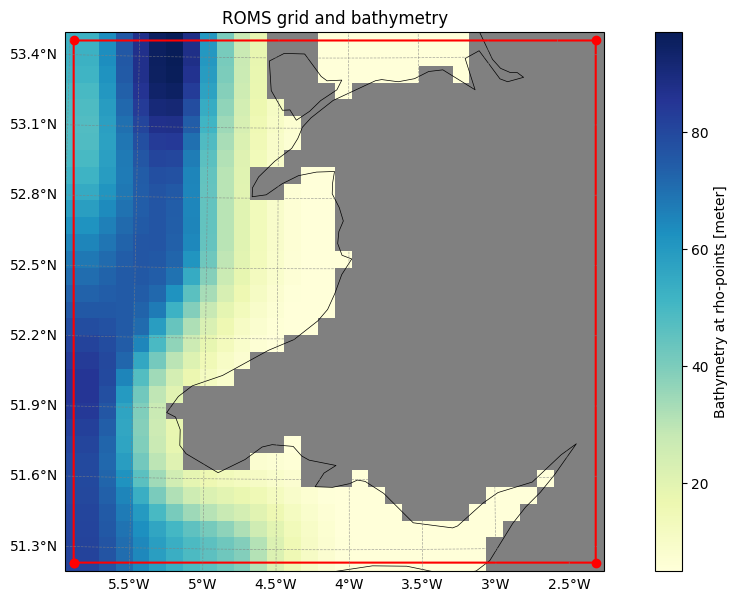

In [10]:
roms_grd = rt.Grid(nx=30,
                   ny = 30,
                   size_x = 240,
                   size_y = 240,
                   N = 20,
                   rot = 0,
                   center_lon = -4.1,
                   center_lat = 52.36)

roms_grd.plot(bathymetry=True)


# Make tides

In [11]:
ls {tpxo_datadir}

tpxo9.v2a.nc*


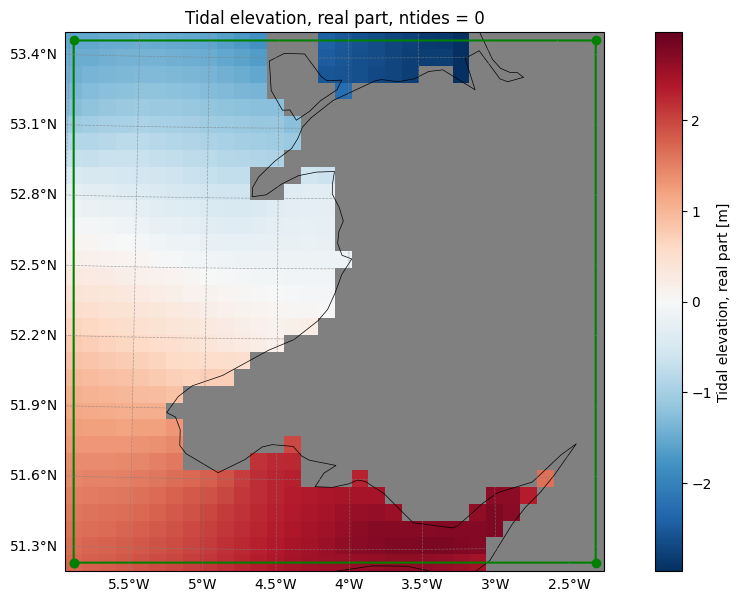

In [12]:
roms_tides = rt.TidalForcing(grid=roms_grd,
                             source = {'name':'TPXO','path': tpxo_datadir / 'tpxo9.v2a.nc'},
                             ntides = 14)
roms_tides.plot("ssh_Re", ntides=0)


# Atmospheric forcing (physics)

In [13]:
# %%time
roms_frc = rt.SurfaceForcing(
    grid=roms_grd,
    start_time=start_time,
    end_time=end_time,
    source={"name": "ERA5", "path": era5_datadir/"ERA5_2012-01.nc"},
    correct_radiation=True,
    use_coarse_grid=False,
    type="physics",  # "physics" or "bgc"; default is "physics"
)

WARNING - No records found at or after the end_time.


# Atmospheric forcing (BGC)

In [14]:
# %%time
roms_frc_bgc = rt.SurfaceForcing(
    grid=roms_grd,
    start_time=start_time,
    end_time=end_time,
    source={"name": "CESM_REGRIDDED", "path": cesm_datadir/"CESM-surface_lowres_regridded.nc"},
    type="bgc",
)

# Initial conditions

INFO - Selected time entry closest to the specified start_time (2012-01-01 00:00:00) within the range [2012-01-01 00:00:00, 2012-01-02 00:00:00]: ['2012-01-01T12:00:00.000000000']


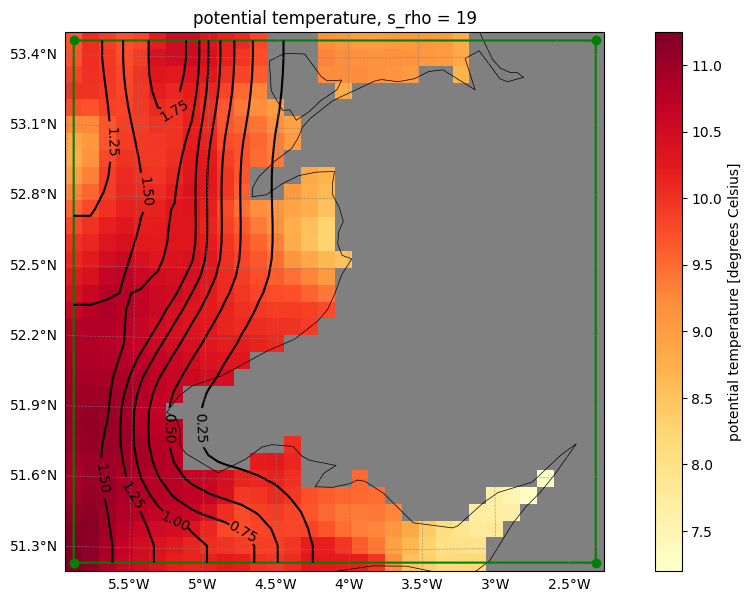

In [15]:
# %%time
ini_time=dt.datetime(2012,1,1)
roms_ini = rt.InitialConditions(
    grid=roms_grd,
    ini_time=ini_time,
    source={"name" : "GLORYS",
                    "path" : glorys_datadir/"mercatorglorys12v1_gl12_mean_20120101.nc"},
    bgc_source={"name": "CESM_REGRIDDED",
                "path": cesm_datadir/"CESM-climatology_lowres_regridded.nc",
                "climatology": True,
    },
)
roms_ini.plot("temp", s=-1, depth_contours=True)


# Boundary conditions

In [16]:
roms_bry = rt.BoundaryForcing(
    grid=roms_grd,
    start_time=start_time,
    end_time=end_time,
    source={"name": "GLORYS", "path": glorys_datadir/"mercatorglorys*.nc"},
    apply_2d_horizontal_fill=True,
    boundaries = {
        "south": True,
        "east": False,
        "north": True,
        "west": True,
    },
    use_dask=True
)

WARNING - No records found at or before the start_time.


In [17]:

roms_bry_bgc = rt.BoundaryForcing(
    grid = roms_grd,
    start_time = start_time,
    end_time = end_time,
    source={"name": "CESM_REGRIDDED", 
            "path": cesm_datadir/"CESM-climatology_lowres_regridded.nc", 
            "climatology": True},
    type="bgc",
    apply_2d_horizontal_fill=True,
    boundaries = {
        "south": True,
        "east": False,
        "north": True,
        "west": True,
    },
    use_dask=True    
)
# Save yaml



# River forcing

In [18]:
roms_riv_frc = rt.RiverForcing(
    grid=roms_grd,
    start_time=start_time,
    end_time=end_time,
    convert_to_climatology="if_any_missing",  # "never", "always", or "if_any_missing" (default)
)


INFO - Compute climatology for river forcing.


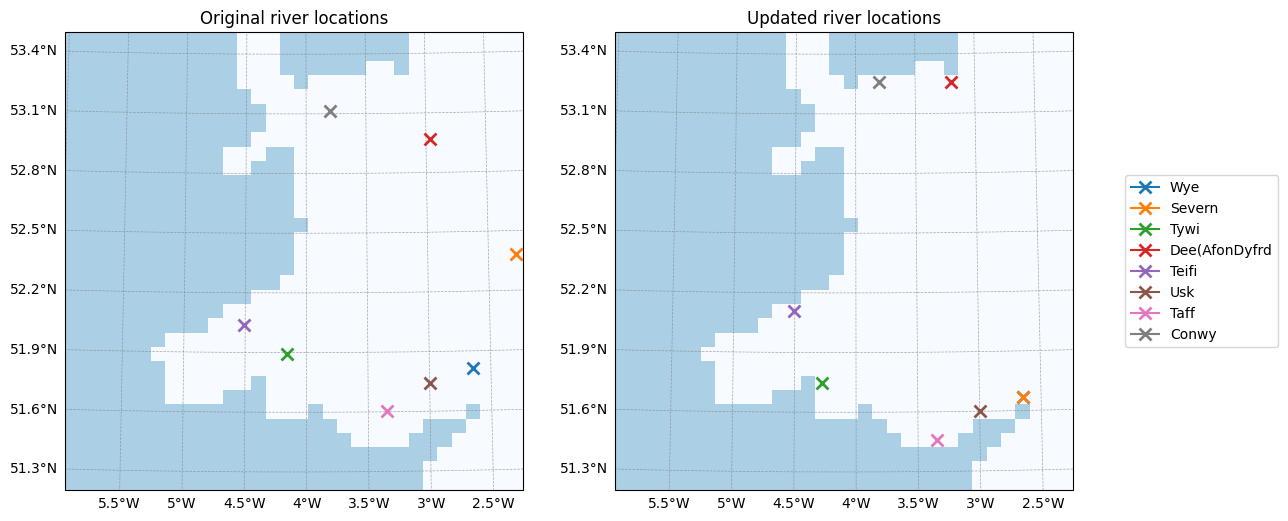

In [19]:
roms_riv_frc.plot_locations()

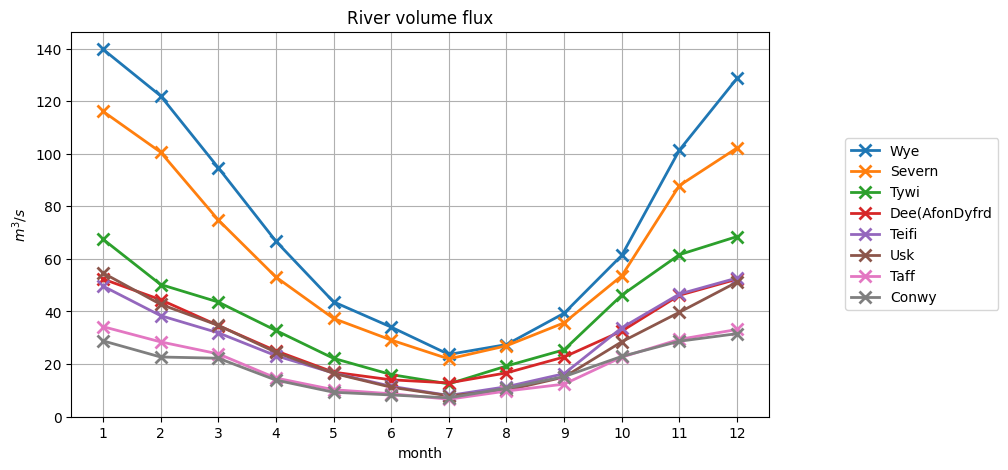

In [20]:
roms_riv_frc.plot("river_volume")

# Save all to yaml:

In [21]:
roms_grd.to_yaml(yamldir/"roms_grd.yaml")
roms_tides.to_yaml(yamldir/"roms_tides.yaml")
roms_frc.to_yaml(yamldir/'roms_frc.yaml')
roms_frc_bgc.to_yaml(yamldir/'roms_frc_bgc.yaml')
roms_ini.to_yaml(yamldir/'roms_ini.yaml')
roms_bry.to_yaml(yamldir/"roms_bry.yaml")
roms_bry_bgc.to_yaml(yamldir/"roms_bry_bgc.yaml")
roms_riv_frc.to_yaml(yamldir/"roms_riv_frc.yaml")

# Save all to netcdf

In [22]:
with ProgressBar():
    roms_grd.save(outdir /"roms_grd")
    roms_tides.save(outdir/'roms_tides.nc')
    roms_frc.save(outdir/'roms_frc')
    roms_frc_bgc.save(filepath=outdir/'roms_frc_bgc')
    roms_ini.save(outdir/"roms_ini.nc")
    roms_bry.save(f"{outdir}/roms_bry") #no .nc again
    roms_bry_bgc.save(f"{outdir}/roms_bry_bgc")    
    roms_riv_frc.save(filepath=outdir/"roms_riv_frc.nc", filepath_grid=outdir/"roms_grd.nc")


[########################################] | 100% Completed | 28.20 s
[########################################] | 100% Completed | 28.28 s
[########################################] | 100% Completed | 38.33 s
[########################################] | 100% Completed | 38.34 s


# Save all to partitioned netcdf

In [23]:
with ProgressBar():
    roms_grd.save(partdir /"roms_grd", np_xi=NP_XI, np_eta=NP_ETA)
    roms_tides.save(partdir/'roms_tides.nc',np_xi=NP_XI,np_eta=NP_ETA)
    roms_frc.save(partdir/'roms_frc',np_xi=NP_XI,np_eta=NP_ETA)
    roms_frc_bgc.save(filepath=partdir/'roms_frc_bgc',np_xi=NP_XI,np_eta=NP_ETA)
    roms_ini.save(partdir/"roms_ini.nc",np_xi=NP_XI,np_eta=NP_ETA)
    roms_bry.save(f"{partdir}/roms_bry",np_xi=NP_XI,np_eta=NP_ETA) #no .nc again
    roms_bry_bgc.save(f"{partdir}/roms_bry_bgc",np_xi=NP_XI,np_eta=NP_ETA) #no .nc again
    roms_riv_frc.save(filepath=partdir/"roms_riv_frc.nc", filepath_grid=partdir/"roms_grd.nc",np_xi=NP_XI,np_eta=NP_ETA)

---



# Make C-Star Case



---


In [70]:
local=False
if local:
    code_location = str(Path.cwd())+"/"
    additional_code_checkout_target = None
    netcdf_dataset_location = str(Path("input_datasets_netcdf/").resolve())+"/"
    yaml_dataset_location = str(Path("input_datasets_yaml/").resolve())+"/"
else:
    additional_code_location = "https://github.com/CWorthy-ocean/cstar_blueprint_roms_marbl_example.git"
    additional_code_checkout_target = "cstar_alpha"
    netcdf_dataset_location = str(Path("input_datasets_netcdf/").resolve()) + "/"# TODO UPDATE
    yaml_dataset_location = "https://github.com/CWorthy-ocean/cstar_blueprint_roms_marbl_example/raw/cstar_alpha/input_datasets_yaml/"

## BaseModel

In [71]:
from cstar.roms import ROMSBaseModel
from cstar.marbl import MARBLBaseModel

roms_base_model = ROMSBaseModel(
    source_repo='https://github.com/CESR-lab/ucla-roms.git',
    checkout_target="52adceac25670ee985d741d1bad62639dac3d183",
)

marbl_base_model = MARBLBaseModel(
    source_repo='https://github.com/marbl-ecosys/MARBL.git',
    checkout_target='marbl0.45.0'
)

## AdditionalCode

In [72]:

from cstar.base import AdditionalCode

roms_namelists = AdditionalCode(
    location = additional_code_location,
    subdir = "roms_runtime_code",
    checkout_target = additional_code_checkout_target    ,
    files = [
        "roms.in_TEMPLATE",
        "marbl_in",
        "marbl_tracer_output_list",
        "marbl_diagnostic_output_list"
    ]
)
print(roms_namelists)

AdditionalCode
--------------
Location: https://github.com/CWorthy-ocean/cstar_blueprint_roms_marbl_example.git
subdirectory: roms_runtime_code
Working path: None
Exists locally: False (get with AdditionalCode.get())
Files:
    roms.in_TEMPLATE      (roms.in will be used by C-Star based on this template)
    marbl_in
    marbl_tracer_output_list
    marbl_diagnostic_output_list


In [73]:
roms_additional_source_code = AdditionalCode(
    location = additional_code_location,
    subdir = "roms_compile_time_code",
    checkout_target = additional_code_checkout_target,
    files = [
        "bgc.opt",
         "bulk_frc.opt",
         "cppdefs.opt",
         "diagnostics.opt",
         "ocean_vars.opt",
         "param.opt",
         "tracers.opt",
         "Makefile",
         "Make.depend",
    ]
)

print(roms_additional_source_code)

AdditionalCode
--------------
Location: https://github.com/CWorthy-ocean/cstar_blueprint_roms_marbl_example.git
subdirectory: roms_compile_time_code
Working path: None
Exists locally: False (get with AdditionalCode.get())
Files:
    bgc.opt
    bulk_frc.opt
    cppdefs.opt
    diagnostics.opt
    ocean_vars.opt
    param.opt
    tracers.opt
    Makefile
    Make.depend


# InputDatasets (netcdf)

In [74]:
%%bash
cd input_datasets_netcdf/
shasum -a 256 *.nc

1b2f1cc83441cc80d45055985a01bfaa0bc698104a2c58a00e7a87fafc214575  roms_bry_bgc.nc
93dc9e8aaebecec61895e344898a7679d058b8c8768436c45e7cfe6d672d5380  roms_bry.nc
43bd29ce46394fd62a9f6da299e8cb414df4b21ccf48c64830ee0f560252af39  roms_frc_bgc.nc
8ef325c9242db183d27bf037b91c57d42fa04d9bb7ec7249fecc53ca707df2fb  roms_frc.nc
84f3667f39add10e977bb87c74c40776641e8fb27ad5d590948c858afe84a045  roms_grd.nc
1ffa9a85fe30c4c6999969e716ff6de833fc901d1cc213e89760bff8c22552bd  roms_ini.nc
60cc745ba0a1054da652cbcb3485200d1a75b49b391d6d75679b18e94a2c369e  roms_riv_frc.nc
a711d31087d2b0ed6569736db5139d17100c041d03484892e241a624eb4f9ea9  roms_tides.nc


In [75]:
from cstar.roms import ROMSModelGrid, ROMSInitialConditions, ROMSTidalForcing, ROMSBoundaryForcing, ROMSSurfaceForcing

# Boundary
roms_phys_boundary_forcing_nc = ROMSBoundaryForcing(
    location=netcdf_dataset_location + "roms_bry.nc",
    file_hash="1b2f1cc83441cc80d45055985a01bfaa0bc698104a2c58a00e7a87fafc214575",
)
roms_bgc_boundary_forcing_nc = ROMSBoundaryForcing(
    location = netcdf_dataset_location+"roms_bry_bgc.nc",
    file_hash = "93dc9e8aaebecec61895e344898a7679d058b8c8768436c45e7cfe6d672d5380",
)

# Surface
roms_phys_surface_forcing_nc = ROMSSurfaceForcing(
    location=netcdf_dataset_location + "roms_frc.nc",
    file_hash="43bd29ce46394fd62a9f6da299e8cb414df4b21ccf48c64830ee0f560252af39",
)
roms_bgc_surface_forcing_nc = ROMSSurfaceForcing(
    location=netcdf_dataset_location + "roms_frc_bgc.nc",
    file_hash="8ef325c9242db183d27bf037b91c57d42fa04d9bb7ec7249fecc53ca707df2fb",
)

#Grid
roms_model_grid_nc = ROMSModelGrid(
    location=netcdf_dataset_location + "roms_grd.nc",
    file_hash="84f3667f39add10e977bb87c74c40776641e8fb27ad5d590948c858afe84a045",
)

# Initial conditions
roms_initial_conditions_nc = ROMSInitialConditions(
    location=netcdf_dataset_location + "roms_ini.nc",
    file_hash="1ffa9a85fe30c4c6999969e716ff6de833fc901d1cc213e89760bff8c22552bd",
)

# Tides
roms_tidal_forcing_nc = ROMSTidalForcing(
    location=netcdf_dataset_location + "roms_tides.nc",
    file_hash="a711d31087d2b0ed6569736db5139d17100c041d03484892e241a624eb4f9ea9",
)



# InputDatasets (yaml)

In [76]:
%%bash
cd input_datasets_yaml/
shasum -a 256 *.yaml

8c144be6ef23e3b91beb37ae9bdd52f582906729f9fd34849838d7ac4d05af36  roms_bry_bgc.yaml
857db7b4ce0daf9bfe12a60a887645c49656c4d585286ca0c3715046fc8f3568  roms_bry.yaml
2858a657b086a24764d25957b2d39893450321d6ed89ce7c88307e9f4eea2341  roms_frc_bgc.yaml
b529ba66a6856a040bb3a21f90a2b4f2d62ecb2cd747ba81d0253d1b157846a9  roms_frc.yaml
00f5cfed8eed278f9eb3c207158ab7d3ecec8c3c5bbf39265ace25a9492a44f9  roms_grd.yaml
1d60e298e428a7c6dc399464e00e72cf755416b4b1b0bd9f754a08fac2d73da6  roms_ini.yaml
8376a467ffef06d97af842ef602453a24d810086e7c3f75483d3a38cd0594d83  roms_riv_frc.yaml
17e82347efab35e6508a0671a698bae8e93e1e944fc9afdb03ed19e3e363c7c4  roms_tides.yaml


In [77]:
from cstar.roms import ROMSModelGrid, ROMSInitialConditions, ROMSTidalForcing, ROMSBoundaryForcing, ROMSSurfaceForcing

# Boundary
roms_bgc_boundary_forcing_yaml = ROMSBoundaryForcing(
    location = yaml_dataset_location + "roms_bry_bgc.yaml",
    file_hash = "8c144be6ef23e3b91beb37ae9bdd52f582906729f9fd34849838d7ac4d05af36",
)
roms_phys_boundary_forcing_yaml = ROMSBoundaryForcing(
    location=yaml_dataset_location + "roms_bry.yaml",
    file_hash="857db7b4ce0daf9bfe12a60a887645c49656c4d585286ca0c3715046fc8f3568",
)


# Surface
roms_bgc_surface_forcing_yaml = ROMSSurfaceForcing(
    location=yaml_dataset_location + "roms_frc_bgc.yaml",
    file_hash="2858a657b086a24764d25957b2d39893450321d6ed89ce7c88307e9f4eea2341",
)
roms_phys_surface_forcing_yaml = ROMSSurfaceForcing(
    location=yaml_dataset_location + "roms_frc.yaml",
    file_hash="b529ba66a6856a040bb3a21f90a2b4f2d62ecb2cd747ba81d0253d1b157846a9",
)

#Grid
roms_model_grid_yaml = ROMSModelGrid(
    location=yaml_dataset_location + "roms_grd.yaml",
    file_hash="00f5cfed8eed278f9eb3c207158ab7d3ecec8c3c5bbf39265ace25a9492a44f9",
)

# Initial conditions
roms_initial_conditions_yaml = ROMSInitialConditions(
    location=yaml_dataset_location + "roms_ini.yaml",
    file_hash="1d60e298e428a7c6dc399464e00e72cf755416b4b1b0bd9f754a08fac2d73da6",
)

# Tides
roms_tidal_forcing_yaml = ROMSTidalForcing(
    location=yaml_dataset_location + "roms_tides.yaml",
    file_hash="17e82347efab35e6508a0671a698bae8e93e1e944fc9afdb03ed19e3e363c7c4",
)



## Discretization

In [78]:
from cstar.roms import ROMSDiscretization

roms_discretization = ROMSDiscretization(time_step = 720,
                                         n_procs_x = 3,
                                         n_procs_y = 3)
print(roms_discretization)

ROMSDiscretization
------------------
time_step: 720s
n_procs_x: 3 (Number of x-direction processors)
n_procs_y: 3 (Number of y-direction processors)


# Make Components

In [79]:
from cstar.roms import ROMSComponent
from cstar.marbl import MARBLComponent

In [80]:
marbl_component = MARBLComponent(
    base_model = marbl_base_model
)
print(marbl_component)

MARBLComponent
--------------
base_model: MARBLBaseModel instance (query using Component.base_model)


In [81]:
roms_component_nc = ROMSComponent(
    base_model = roms_base_model,
    namelists = roms_namelists,
    additional_source_code = roms_additional_source_code,
    discretization = roms_discretization,
    model_grid = roms_model_grid_nc,
    initial_conditions = roms_initial_conditions_nc,
    tidal_forcing = roms_tidal_forcing_nc,
    boundary_forcing = [roms_phys_boundary_forcing_nc,roms_bgc_boundary_forcing_nc],
    surface_forcing = [roms_phys_surface_forcing_nc, roms_bgc_surface_forcing_nc]
)
print(roms_component_nc)



ROMSComponent
-------------
base_model: ROMSBaseModel instance (query using Component.base_model)
additional_source_code: AdditionalCode instance with 9 files (query using Component.additional_source_code)
namelists: AdditionalCode instance with 4 files (query using Component.namelists)
model_grid = <ROMSModelGrid instance>
initial_conditions = <ROMSInitialConditions instance>
tidal_forcing = <ROMSTidalForcing instance>
surface_forcing = <list of 2 ROMSSurfaceForcing instances>
boundary_forcing = <list of 2 ROMSBoundaryForcing instances>

Discretization:
ROMSDiscretization
------------------
time_step: 720s
n_procs_x: 3 (Number of x-direction processors)
n_procs_y: 3 (Number of y-direction processors)


In [82]:
roms_component_yaml = ROMSComponent(
    base_model = roms_base_model,
    namelists = roms_namelists,
    additional_source_code = roms_additional_source_code,
    discretization = roms_discretization,
    model_grid = roms_model_grid_yaml,
    initial_conditions = roms_initial_conditions_yaml,
    tidal_forcing = roms_tidal_forcing_yaml,
    boundary_forcing = [roms_phys_boundary_forcing_yaml,roms_bgc_boundary_forcing_yaml],
    surface_forcing = [roms_phys_surface_forcing_yaml, roms_bgc_surface_forcing_yaml]
)
print(roms_component_yaml)



ROMSComponent
-------------
base_model: ROMSBaseModel instance (query using Component.base_model)
additional_source_code: AdditionalCode instance with 9 files (query using Component.additional_source_code)
namelists: AdditionalCode instance with 4 files (query using Component.namelists)
model_grid = <ROMSModelGrid instance>
initial_conditions = <ROMSInitialConditions instance>
tidal_forcing = <ROMSTidalForcing instance>
surface_forcing = <list of 2 ROMSSurfaceForcing instances>
boundary_forcing = <list of 2 ROMSBoundaryForcing instances>

Discretization:
ROMSDiscretization
------------------
time_step: 720s
n_procs_x: 3 (Number of x-direction processors)
n_procs_y: 3 (Number of y-direction processors)


# Make Cases

In [83]:
from cstar import Case

In [84]:
roms_marbl_case_nc = Case(
    components=[marbl_component, roms_component_nc],
    name='roms_marbl_example_cstar_case_nc',
    start_date = "20120101 12:00:00",
    end_date = "20120110 12:00:00",
    caseroot = "roms_marbl_example_cstar_case_netcdf",
    valid_start_date = "20120101 12:00:00",
    valid_end_date = "20120131 12:00:00"
)
print(roms_marbl_case_nc)
roms_marbl_case_nc.to_blueprint("cstar_blueprint_example_with_netcdf_inputs.yaml")

C-Star Case
-----------
Name: roms_marbl_example_cstar_case_nc
caseroot: /global/cfs/cdirs/m4746/Users/dafydd/my_c_star/blueprints/cstar_blueprint_roms_marbl_example/roms_marbl_example_cstar_case_netcdf
start_date: 2012-01-01 12:00:00
end_date: 2012-01-10 12:00:00
Is setup: False
Valid date range:
valid_start_date: 2012-01-01 12:00:00
valid_end_date: 2012-01-31 12:00:00

It is built from the following Components (query using Case.components): 
   <MARBLComponent instance>
   <ROMSComponent instance>


In [86]:
roms_marbl_case_yaml = Case(
    components=[marbl_component, roms_component_yaml],
    name='roms_marbl_example_cstar_case_yaml',
    start_date = "20120101 12:00:00",
    end_date = "20120110 12:00:00",
    caseroot = "roms_marbl_example_cstar_case_yaml",
    valid_start_date = "20120101 12:00:00",
    valid_end_date = "20120131 12:00:00"
)
print(roms_marbl_case_yaml)
roms_marbl_case_yaml.to_blueprint("cstar_blueprint_example_without_prepared_inputs.yaml")

C-Star Case
-----------
Name: roms_marbl_example_cstar_case_yaml
caseroot: /global/cfs/cdirs/m4746/Users/dafydd/my_c_star/blueprints/cstar_blueprint_roms_marbl_example/roms_marbl_example_cstar_case_yaml
start_date: 2012-01-01 12:00:00
end_date: 2012-01-10 12:00:00
Is setup: False
Valid date range:
valid_start_date: 2012-01-01 12:00:00
valid_end_date: 2012-01-31 12:00:00

It is built from the following Components (query using Case.components): 
   <MARBLComponent instance>
   <ROMSComponent instance>


# Setup and run (yaml)

In [87]:
roms_marbl_case_yaml.setup()
roms_marbl_case_yaml.build()
roms_marbl_case_yaml.pre_run()


Setting up MARBLComponent
--------------------------
Configuring MARBLComponent
--------------------------
MARBLBaseModel correctly configured. Nothing to be done

Setting up ROMSComponent
-------------------------
Configuring ROMSComponent
-------------------------
ROMSBaseModel correctly configured. Nothing to be done

Fetching additional source code...
----------------------------------
Cloned repository https://github.com/CWorthy-ocean/cstar_blueprint_roms_marbl_example.git to /tmp/tmphpgrc9gw
Checked out cstar_alpha in git repository /tmp/tmphpgrc9gw
copying bgc.opt to /global/cfs/cdirs/m4746/Users/dafydd/my_c_star/blueprints/cstar_blueprint_roms_marbl_example/roms_marbl_example_cstar_case_yaml/additional_source_code/ROMS
copying bulk_frc.opt to /global/cfs/cdirs/m4746/Users/dafydd/my_c_star/blueprints/cstar_blueprint_roms_marbl_example/roms_marbl_example_cstar_case_yaml/additional_source_code/ROMS
copying cppdefs.opt to /global/cfs/cdirs/m4746/Users/dafydd/my_c_star/blueprints/c

Cloned repository https://github.com/CWorthy-ocean/cstar_blueprint_roms_marbl_example.git to /tmp/tmpdtikfure
Checked out cstar_alpha in git repository /tmp/tmpdtikfure
copying roms.in_TEMPLATE to /global/cfs/cdirs/m4746/Users/dafydd/my_c_star/blueprints/cstar_blueprint_roms_marbl_example/roms_marbl_example_cstar_case_yaml/namelists/ROMS
copying template file /global/cfs/cdirs/m4746/Users/dafydd/my_c_star/blueprints/cstar_blueprint_roms_marbl_example/roms_marbl_example_cstar_case_yaml/namelists/ROMS/roms.in_TEMPLATE to editable version /global/cfs/cdirs/m4746/Users/dafydd/my_c_star/blueprints/cstar_blueprint_roms_marbl_example/roms_marbl_example_cstar_case_yaml/namelists/ROMS/roms.in
copying marbl_in to /global/cfs/cdirs/m4746/Users/dafydd/my_c_star/blueprints/cstar_blueprint_roms_marbl_example/roms_marbl_example_cstar_case_yaml/namelists/ROMS
copying marbl_tracer_output_list to /global/cfs/cdirs/m4746/Users/dafydd/my_c_star/blueprints/cstar_blueprint_roms_marbl_example/roms_marbl_exam

Saving roms-tools dataset created from /global/cfs/cdirs/m4746/Users/dafydd/my_c_star/blueprints/cstar_blueprint_roms_marbl_example/roms_marbl_example_cstar_case_yaml/input_datasets/ROMS/roms_grd.yaml...


INFO - Selected time entry closest to the specified start_time (2012-01-01 12:00:00) within the range [2012-01-01 12:00:00, 2012-01-02 12:00:00]: ['2012-01-01T12:00:00.000000000']


Saving roms-tools dataset created from /global/cfs/cdirs/m4746/Users/dafydd/my_c_star/blueprints/cstar_blueprint_roms_marbl_example/roms_marbl_example_cstar_case_yaml/input_datasets/ROMS/roms_ini.yaml...
[########################################] | 100% Completed | 7.08 sms


Saving roms-tools dataset created from /global/cfs/cdirs/m4746/Users/dafydd/my_c_star/blueprints/cstar_blueprint_roms_marbl_example/roms_marbl_example_cstar_case_yaml/input_datasets/ROMS/roms_tides.yaml...
[########################################] | 100% Completed | 3.58 sms


Saving roms-tools dataset created from /global/cfs/cdirs/m4746/Users/dafydd/my_c_star/blueprints/cstar_blueprint_roms_marbl_example/roms_marbl_example_cstar_case_yaml/input_datasets/ROMS/roms_bry.yaml...
[########################################] | 100% Completed | 9.71 ss


Saving roms-tools dataset created from /global/cfs/cdirs/m4746/Users/dafydd/my_c_star/blueprints/cstar_blueprint_roms_marbl_example/roms_marbl_example_cstar_case_yaml/input_datasets/ROMS/roms_bry_bgc.yaml...
[########################################] | 100% Completed | 38.83 s


Saving roms-tools dataset created from /global/cfs/cdirs/m4746/Users/dafydd/my_c_star/blueprints/cstar_blueprint_roms_marbl_example/roms_marbl_example_cstar_case_yaml/input_datasets/ROMS/roms_frc.yaml...
[########################################] | 100% Completed | 16.02 s


Saving roms-tools dataset created from /global/cfs/cdirs/m4746/Users/dafydd/my_c_star/blueprints/cstar_blueprint_roms_marbl_example/roms_marbl_example_cstar_case_yaml/input_datasets/ROMS/roms_frc_bgc.yaml...
[########################################] | 100% Completed | 504.50 ms

Compiling MARBLComponent
-------------------------
No build steps to be completed for MARBLComponent

Compiling ROMSComponent
------------------------
Compiling UCLA-ROMS configuration...
UCLA-ROMS compiled at /global/cfs/cdirs/m4746/Users/dafydd/my_c_star/blueprints/cstar_blueprint_roms_marbl_example/roms_marbl_example_cstar_case_yaml/additional_source_code/ROMS

Completing pre-processing steps for MARBLComponent
---------------------------------------------------
No pre-processing steps to be completed for MARBLComponent

Completing pre-processing steps for ROMSComponent
--------------------------------------------------
Partitioning /global/cfs/cdirs/m4746/Users/dafydd/my_c_star/blueprints/cstar_blueprint_r

In [88]:
import os

In [91]:
lp_yaml=roms_marbl_case_yaml.run(account_key = os.environ.get("ACCOUNT_KEY"),queue_name="shared",walltime="00:10:00")


Running ROMS... 


In [102]:
lp_yaml.status

<ExecutionStatus.PENDING: 2>

In [101]:
%%bash
squeue -u dafydd

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          34904198 shared_mi cstar_jo   dafydd PD       0:00      1 (Priority)
          34894420 urgent_mi  jupyter   dafydd  R    4:15:01      1 nid200003


In [95]:
lp_yaml.updates(seconds=0,confirm_indefinite=False)

This job is currently not running (pending). Live updates cannot be provided.


In [ ]:
roms_marbl_case_yaml.post_run()

# Setup and run (netcdf)

In [ ]:
roms_marbl_case_nc.setup()
roms_marbl_case_nc.build()
roms_marbl_case_nc.pre_run()
lp=roms_marbl_case_nc.run()

In [ ]:
lp.updates(seconds=0,confirm_indefinite=False)

In [ ]:
roms_marbl_case_nc.post_run()